## New Adjusted Analysis

## Rolling Quantile Version

In [1]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor



/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,


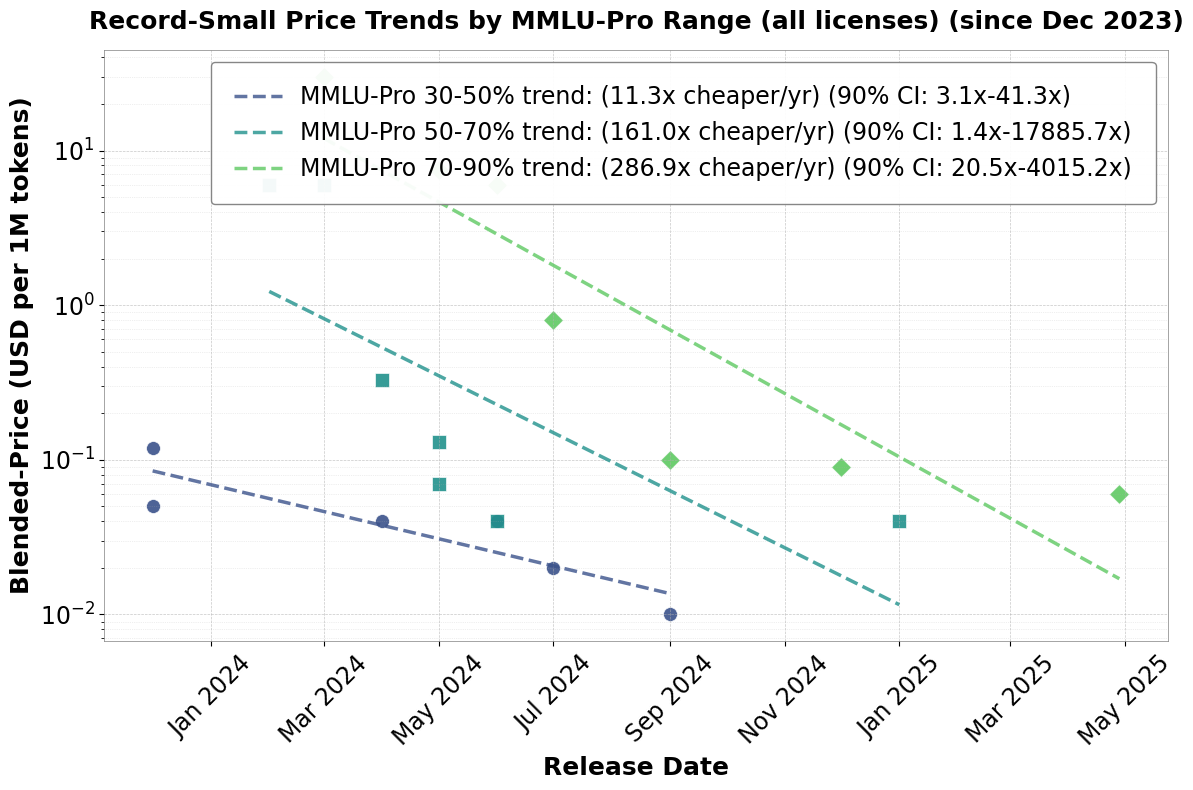

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2242269543.py:192: RuntimeWarning: overflow encountered in power
  10**y_upper,


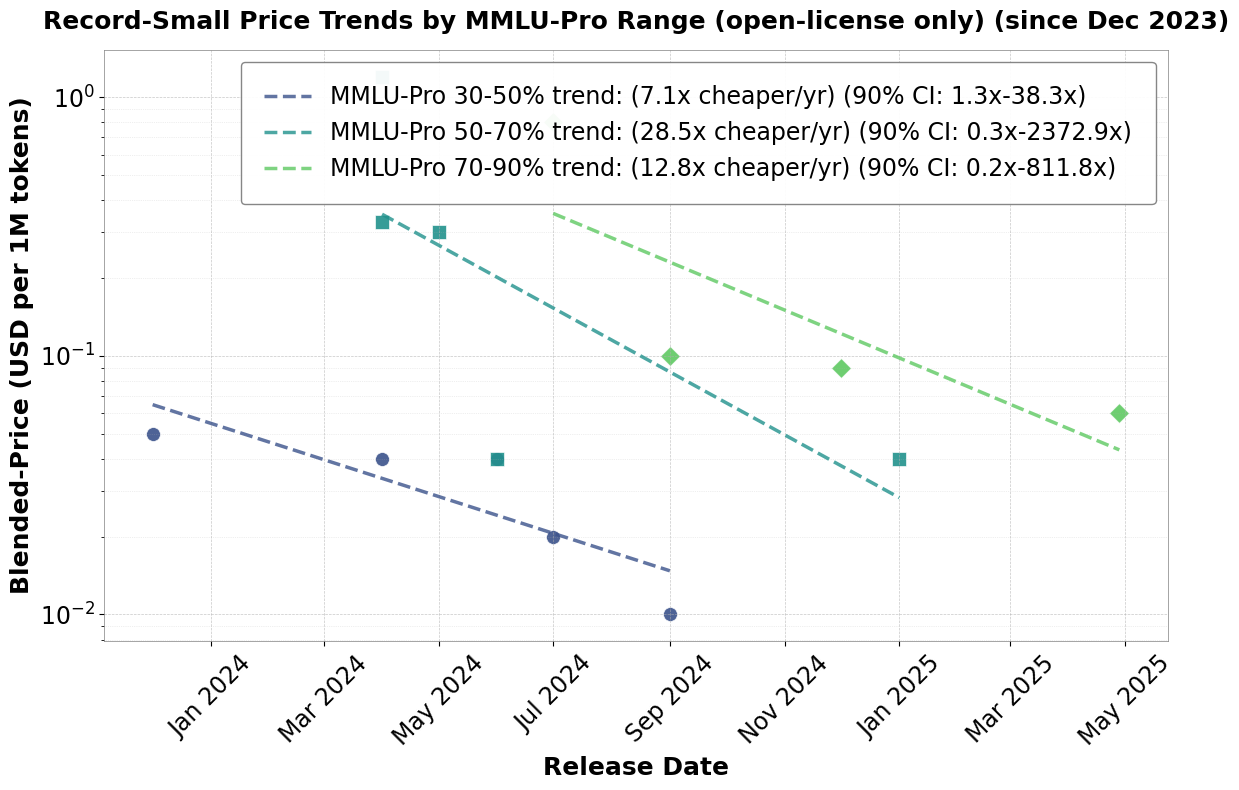

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scienceplots
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats


# get predictions at highly skewed
#R^2 regression


def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False, min_date=datetime(2023, 1, 1), confidence_interval=True, include_chinese=None, benchmark_col='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plot record-small points and their trend lines for three MMLU ranges (30-50, 50-70, 70-90) 
    on a single graph with enhanced styling. Includes 90% confidence intervals.
    
    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data (default: 'Lowest Blended Price AA')
      show_model_names: If True, displays model names next to record-small points
      min_date: If provided, only include models released on or after this date (datetime or string)
                Default is January 1, 2024
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: Filter for Chinese models - if True, only include Chinese models; 
                      if False, exclude Chinese models; if None, include all models
      benchmark_col: Column name for the benchmark to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Define MMLU ranges with custom palette
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D']  # Diamond, square, diamond
    
    # --- column names ---
    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    
    # Store all data for setting axis limits
    all_dates = []
    all_prices = []
    
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i]
        
        # 1) Work on a copy
        df_work = df.copy()

        # 2) Convert MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%','',regex=False)
                             .astype(float)
        )

        # 3) Convert price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # 4) Optionally filter to open‐license only
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # 4b) Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
            
        # 4c) Filter by Chinese models if specified
        if include_chinese is not None:
            if include_chinese:
                # Only include Chinese models (where Chinese column is TRUE)
                df_work = df_work[df_work[chinese_col] == True]
            else:
                # Exclude Chinese models (where Chinese column is TRUE)
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]

        # 5) Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # 6) Drop missing Release Date or price, remove non‐positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        # Skip if no data
        if len(df_sub) == 0:
            continue

        # 7) Sort & compute ordinal date
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

        # 8) "Record‐small" = running minima of price
        df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        # Skip if no record small points
        if len(record_small) == 0:
            continue

        # 9) Linear regression on record small points (log scale)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # 10) Create prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
        # 11) Calculate annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            # Convert to annual factors
            annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
            annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"

        # 12) Plot record small points with enhanced styling
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small[price_col],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        # 13) Plot trend line with enhanced styling
        ax.plot(
            x_dates, 
            10**y_rec_log_pred, 
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'{benchmark_col.split(" ")[0]} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )
        
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )
        
        # 14) Add model names if requested
        if show_model_names:
            for idx, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row[price_col]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )
        
        # Store data for axis limits
        all_dates.extend(record_small['Release Date'].tolist())
        all_prices.extend(record_small[price_col].tolist())
    
    # 15) Enhanced formatting
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
    ax.set_ylabel('Blended-Price (USD per 1M tokens)', fontsize=18, fontweight='bold')
    
    # Format date axis
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
    benchmark_name = benchmark_col.split(" ")[0]  # Extract first part of benchmark name for title
    ax.set_title(f'Record-Small Price Trends by {benchmark_name} Range ({lic_label}){date_filter}{chinese_filter}',     fontsize=18, fontweight='bold', pad=15)
    
# \n{price_col}


    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.show()

# Usage examples:
# For all licenses:
plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA", min_date=datetime(2023, 12, 1), confidence_interval=True)

# For open licenses only with model names:
plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", show_model_names=False, confidence_interval=True, min_date=datetime(2023, 12, 1))

# # For Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=True)

# # For non-Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=False)

In [4]:

df = pd.read_csv('art_analysis_inf_data.csv')
print(df.columns)
#convert price to float
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Output Price Found 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2965051322.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


NameError: name 'sns' is not defined

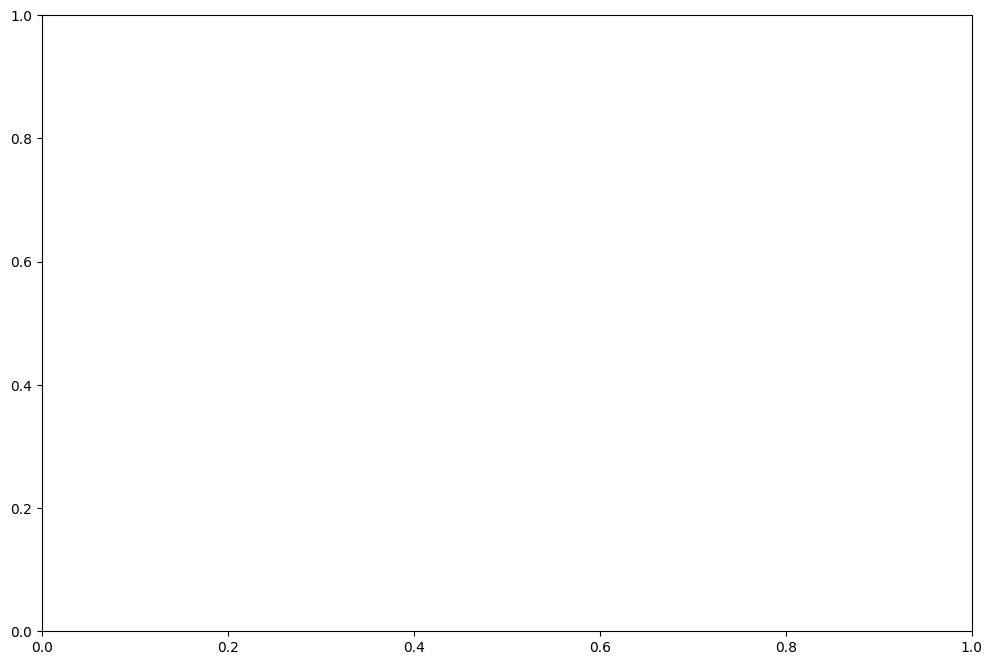

In [5]:
def plot_combined_rolling_quantile_trends(
        open_license_only=False,
        price_col='Lowest Blended Price AA',
        show_model_names=False,
        min_date=datetime(2023, 1, 1),
        include_chinese=None,
        benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
        window_days=60,               # rolling-window width in days
        q=0.25,                       # quantile level (25-th percentile)
        confidence_interval=True):
    """
    Same idea as plot_combined_record_small_trends, but uses a rolling
    quantile instead of record-small points.
    """
    # ------------- styling boilerplate -----------------
    plt.rcParams['font.family'] = 'sans-serif'
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    mmlu_ranges  = [(30, 50), (50, 70), (70, 90)]
    palette      = sns.color_palette("viridis", len(mmlu_ranges))
    markers      = ['o', 's', 'D']
    license_col  = 'License'
    chinese_col  = 'Chinese'

    # Track all valid values for setting axis limits
    all_y_values = []

    # ---------------------------------------------------
    for i, (lo_mmlu, hi_mmlu) in enumerate(mmlu_ranges):
        color, marker = palette[i], markers[i]

        # --- build working frame -------------------------------------------------
        df_work = df.copy()

        # benchmark → float %
        df_work[benchmark_col] = (df_work[benchmark_col].astype(str)
                                  .str.replace('%', '', regex=False)
                                  .astype(float))

        # price → float
        df_work[price_col] = (df_work[price_col].astype(str)
                              .str.replace(r'[$,]', '', regex=True))
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # filters ---------------------------------------------------------------
        if open_license_only:
            df_work = df_work[df_work[license_col].notna() &
                              df_work[license_col].str.contains('open', case=False, na=False)]

        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]

        if include_chinese is not None:
            if include_chinese:
                df_work = df_work[df_work[chinese_col] == True]
            else:
                df_work = df_work[(df_work[chinese_col] != True) |
                                  (df_work[chinese_col].isna())]

        df_sub = df_work[df_work[benchmark_col].between(lo_mmlu, hi_mmlu)].copy()
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]
        
        if df_sub.empty:
            continue

        # -----------------------------------------------------------------------
        # Build rolling quantile manually
        # -----------------------------------------------------------------------
        df_sub = df_sub.sort_values('Release Date')
        
        # Create date range from first to last release date
        start_date = df_sub['Release Date'].min()
        end_date = df_sub['Release Date'].max()
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        # Calculate rolling quantile for each date
        rolling_quantiles = []
        rolling_dates = []
        
        for current_date in date_range:
            # Look back window_days from current_date
            window_start = current_date - pd.Timedelta(days=window_days)
            
            # Get all models released in this window
            window_models = df_sub[
                (df_sub['Release Date'] >= window_start) & 
                (df_sub['Release Date'] <= current_date)
            ]
            
            if len(window_models) >= 1:  # Need at least 1 model for quantile
                quantile_price = window_models[price_col].quantile(q)
                if pd.notna(quantile_price) and quantile_price > 0:
                    rolling_quantiles.append(quantile_price)
                    rolling_dates.append(current_date)
        
        if len(rolling_quantiles) < 2:
            print(f"Not enough data points for MMLU range {lo_mmlu}-{hi_mmlu}")
            continue
            
        # Convert to arrays for regression
        rolling_dates = pd.to_datetime(rolling_dates)
        rolling_quantiles = np.array(rolling_quantiles)
        
        # Store values for axis limits
        all_y_values.extend(rolling_quantiles)

        # -----------------------------------------------------------------------
        # regression on log10(price) vs ordinal date
        # -----------------------------------------------------------------------
        date_ordinal = rolling_dates.map(datetime.toordinal).values.reshape(-1, 1)
        y_log = np.log10(rolling_quantiles)
        
        # Check for any infinite or NaN values
        if not np.all(np.isfinite(y_log)):
            print(f"Invalid log values for MMLU range {lo_mmlu}-{hi_mmlu}")
            continue
            
        reg = LinearRegression().fit(date_ordinal, y_log)

        # prediction grid
        x_range = np.arange(date_ordinal.min(), date_ordinal.max() + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_pred_log = reg.predict(x_range.reshape(-1, 1))
        
        # Check for reasonable prediction values and clip if necessary
        y_pred_log = np.clip(y_pred_log, -10, 10)  # Reasonable range for log10(price)
        y_pred = 10**y_pred_log
        
        # Validate all prediction values are finite
        if not np.all(np.isfinite(y_pred)):
            print(f"Invalid prediction values for MMLU range {lo_mmlu}-{hi_mmlu}")
            continue

        # annual % decrease & ×-cheaper factor with overflow protection
        slope_daily = reg.coef_[0]
        
        # Calculate annual metrics with protection
        try:
            # Limit the slope to prevent overflow
            slope_daily_safe = np.clip(slope_daily, -1e-3, 1e-3)  # Reasonable daily slope range
            
            annual_pct = ((10**slope_daily_safe)**365 - 1) * 100
            if slope_daily_safe < 0:
                annual_factor = 1 / (10**slope_daily_safe)**365
                if annual_factor > 1000:  # Cap extremely large factors
                    annual_factor_str = ">1000×"
                else:
                    annual_factor_str = f"{annual_factor:.1f}×"
            else:
                annual_factor_str = f"+{annual_pct:.1f}%"
            
            ci_label = ""
            # Skip CI for now to avoid overflow issues
            
        except (OverflowError, ValueError) as e:
            print(f"Overflow in calculations for MMLU range {lo_mmlu}-{hi_mmlu}: {e}")
            annual_factor_str = "extreme"
            ci_label = ""

        # ----------------------------- plotting -------------------------------
        try:
            # raw model dots (faded) - only plot finite values
            valid_mask = np.isfinite(df_sub[price_col]) & (df_sub[price_col] > 0)
            if valid_mask.any():
                sns.scatterplot(data=df_sub[valid_mask], x='Release Date', y=price_col,
                                color=color, alpha=0.25, s=25, ax=ax)

            # daily q-th quantile (small markers)
            ax.scatter(rolling_dates, rolling_quantiles,
                       color=color, marker=marker, s=60, linewidth=0.4,
                       edgecolor='white', zorder=3)

            # trend line - only plot finite values
            finite_mask = np.isfinite(y_pred)
            if finite_mask.any():
                ax.plot(np.array(x_dates)[finite_mask], y_pred[finite_mask], 
                        color=color, ls='--', lw=2.5,
                        label=f'{benchmark_col.split(" ")[0]} {lo_mmlu}-{hi_mmlu}% '
                              f'rolling {int(q*100)}th pct: {annual_factor_str}/yr'
                              f'{ci_label}')
                
        except Exception as e:
            print(f"Error plotting for MMLU range {lo_mmlu}-{hi_mmlu}: {e}")
            continue

    # ------------------ cosmetic stuff ---------------------------------------
    try:
        ax.set_yscale('log')
        ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
        ax.set_ylabel('Blended-Price (USD per 1M tokens)', fontsize=18, fontweight='bold')

        # Set reasonable y-axis limits if we have data
        if all_y_values:
            y_min, y_max = min(all_y_values), max(all_y_values)
            ax.set_ylim(y_min * 0.5, y_max * 2)

        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        plt.xticks(rotation=45)

        lic_lab = 'open-license only' if open_license_only else 'all licenses'
        date_lab = f' (since {min_date.strftime("%b %Y")})' if min_date else ''
        chi_lab = (' (Chinese models only)' if include_chinese is True else
                   ' (non-Chinese models)' if include_chinese is False else '')
        ax.set_title(f'Rolling {int(q*100)}th-Percentile Price ({window_days}-day window)\n'
                     f'by {benchmark_col.split(" ")[0]} band – {lic_lab}{date_lab}{chi_lab}',
                     fontsize=18, fontweight='bold', pad=16)

        ax.grid(True, which='major', ls='--', lw=0.5, alpha=0.7)
        ax.grid(True, which='minor', ls=':', lw=0.5, alpha=0.4)

        ax.legend(loc='upper right', fontsize=15, frameon=True, fancybox=True,
                  framealpha=0.95, edgecolor='gray', borderpad=1)
        ax.tick_params(axis='both', which='major', labelsize=16)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('gray')
            spine.set_linewidth(0.5)

        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in final formatting: {e}")
        plt.show()  # Try to show the plot anyway

# Example
plot_combined_rolling_quantile_trends(
    open_license_only=True,
    price_col='Lowest Blended Price AA',
    min_date=datetime(2023, 12, 1),
    window_days=60,
    q=0.5,
    confidence_interval=False  # Disable CI to avoid overflow
)

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Output Price Found 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_74721/2965051322.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
